In [2]:
!where python

C:\Users\Parth Badani\Anaconda3\envs\snowpark_env\python.exe
C:\Users\Parth Badani\AppData\Local\Programs\Python\Python312\python.exe


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

In [5]:
# Helper functions
def generate_company_name():
    prefixes = ['Tech', 'Global', 'Digital', 'Smart', 'Cloud', 'Next', 'Pro', 'Elite', 'Prime', 'Advanced', 'Logix', 'Coinbase', 'Tex', 'Upstox', 'Helix', 'Genpax', 'Revox', 'Anatoly', 'Bart', 'Celtix', 'Datadex', 'Eulog', 'Frax', 'Gintar', 'Iannis', 'Jenix', 'Kraft', 'Lacer', 'Minex', 'Nagel', 'Onyx', 'Practo', 'Qestar', 'Radex', 'Sweller', 'Tiger']
    suffixes = ['Solutions', 'Systems', 'Technologies', 'Services', 'Innovations', 'Dynamics', 'Labs', 'Group', 'Corp', 'Inc']
    return f"{random.choice(prefixes)}{random.choice(suffixes)}"

def generate_dates(start_date, n_customers):
    # Generate subscription start dates
    start_dates = [start_date + timedelta(days=random.randint(0, 365*2)) for _ in range(n_customers)]

    # Generate end dates (Some will be None for active subscriptions)
    end_dates = []
    for start in start_dates:
        if random.random() < 0.15:  # 15% churn rate
            end_dates.append(start + timedelta(days=random.randint(30, 365)))
        else:
            end_dates.append(None)
    return start_dates, end_dates

In [7]:
# Generate Customer Account Details
n_customers = 5000

# Define company size segments
company_sizes = {
    'SMB': (10, 100),
    'Mid-Market': (101, 500),
    'Enterprise': (501, 5000)
}

# Generate customer accounts
customer_accounts = {
    'customer_id': range(1, n_customers + 1),
    'company_name': [generate_company_name() for _ in range(n_customers)],
    'segment': np.random.choice(['SMB', 'Mid-Market', 'Enterprise'],
                              n_customers, p=[0.65, 0.20, 0.15]),
    'industry': np.random.choice(['Technology', 'Retail', 'Manufacturing', 'Healthcare',
                                'Financial Services/Fintech', 'Education', 'Professional Services',
                                'Media', 'Real Estate', 'Logistics'],
                               n_customers),
    'country': np.random.choice(['USA', 'UK', 'Canada', 'Australia', 'Germany',
                               'France', 'India', 'Singapore', 'Japan', 'Brazil'],
                              n_customers, p=[0.3, 0.15, 0.1, 0.1, 0.08, 0.07, 0.07, 0.05, 0.05, 0.03])
}

# Add company size based on segment
customer_accounts['company_size'] = [
    random.randint(*company_sizes[seg]) for seg in customer_accounts['segment']
]

# Create customer accounts DataFrame
df_customers = pd.DataFrame(customer_accounts)

# Generate Subscription Details
subscription_plans = {
    'Growth': {'base_price': 15, 'max_seats': 70},
    'Pro': {'base_price': 49, 'max_seats': 150},
    'Enterprise': {'base_price': 99, 'max_seats': 100}
}

start_date = datetime(2022, 1, 1)
start_dates, end_dates = generate_dates(start_date, n_customers)

subscriptions = {
    'customer_id': range(1, n_customers + 1),
    'plan': np.random.choice(['Growth', 'Pro', 'Enterprise'],
                           n_customers, p=[0.5, 0.3, 0.2]),
    'start_date': start_dates,
    'end_date': end_dates,
    'is_active': [end_date is None for end_date in end_dates]
}

In [10]:
# Add number of seats and calculate MRR
subscriptions['seats'] = [
    random.randint(5, subscription_plans[plan]['max_seats'])
    for plan in subscriptions['plan']
]

subscriptions['mrr'] = [
    subscription_plans[plan]['base_price'] * seats
    for plan, seats in zip(subscriptions['plan'], subscriptions['seats'])
]

df_subscriptions = pd.DataFrame(subscriptions)

# Generate Usage Metrics (Monthly)
def generate_monthly_usage(n_months, base_logins, base_tickets, trend='stable'):
    # Convert n_months to integer
    n_months = max(1, int(n_months))  # Ensure at least 1 month and convert to integer

    if trend == 'increasing':
        multiplier = np.linspace(1, 1.5, n_months)
    elif trend == 'decreasing':
        multiplier = np.linspace(1, 0.5, n_months)
    else:
        multiplier = np.ones(n_months)

    logins = np.random.normal(base_logins, base_logins * 0.1, n_months) * multiplier
    tickets = np.random.normal(base_tickets, base_tickets * 0.1, n_months) * multiplier
    return logins, tickets

usage_data = []
current_date = datetime.now()

for idx, row in df_subscriptions.iterrows():
    start_date = row['start_date']

    # Handle end_date properly
    if pd.isna(row['end_date']):
        end_date = current_date
    else:
        end_date = row['end_date']

    # Calculate months difference
    months_diff = ((end_date.year - start_date.year) * 12 +
                  (end_date.month - start_date.month))
    n_months = max(1, int(months_diff))

    # Base usage metrics based on plan
    if row['plan'] == 'Enterprise':
        base_logins, base_tickets = 1000, 500
    elif row['plan'] == 'Pro':
        base_logins, base_tickets = 500, 250
    else:
        base_logins, base_tickets = 200, 100

    # Generate monthly usage with random trend
    trend = np.random.choice(['stable', 'increasing', 'decreasing'], p=[0.6, 0.2, 0.2])
    logins, tickets = generate_monthly_usage(n_months, base_logins, base_tickets, trend)

    for month in range(n_months):
        current_date = start_date + timedelta(days=30*month)
        usage_data.append({
            'customer_id': row['customer_id'],
            'month': current_date,
            'logins': int(max(0, logins[month])),
            'tickets_raised': int(max(0, tickets[month])),
            'feature_usage_score': random.uniform(0, 100)
        })

df_usage = pd.DataFrame(usage_data)

In [11]:
# Save to CSV files
df_customers.to_csv('customer_accounts.csv', index=False)
df_subscriptions.to_csv('subscriptions.csv', index=False)
df_usage.to_csv('usage_metrics.csv', index=False)

# Print sample data and summary statistics
print("\nCustomer Accounts Sample:")
print(df_customers.head())
print("\nSubscriptions Sample:")
print(df_subscriptions.head())
print("\nUsage Metrics Sample:")
print(df_usage.head())

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total Customers: {len(df_customers)}")
print(f"Active Subscriptions: {df_subscriptions['is_active'].sum()}")
print(f"Average MRR: ${df_subscriptions['mrr'].mean():.2f}")
print(f"Total MRR: ${df_subscriptions[df_subscriptions['is_active']]['mrr'].sum():.2f}")


Customer Accounts Sample:
   customer_id        company_name segment                    industry  \
0            1           CeltixInc     SMB  Financial Services/Fintech   
1            2         ProDynamics     SMB       Professional Services   
2            3     DatadexServices     SMB                   Education   
3            4       NextSolutions     SMB  Financial Services/Fintech   
4            5  DigitalInnovations     SMB                  Healthcare   

     country  company_size  
0     France            81  
1      Japan            80  
2  Singapore            28  
3     Canada            48  
4  Australia            11  

Subscriptions Sample:
   customer_id    plan start_date   end_date  is_active  seats   mrr
0            1  Growth 2023-11-04        NaT       True     14   210
1            2  Growth 2022-01-31        NaT       True     41   615
2            3     Pro 2022-09-08 2023-06-16      False    132  6468
3            4  Growth 2023-03-24        NaT       True

In [15]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\Parth Badani


In [17]:
!pip install snowflake-connector-python

Now we work on modeling the existing and engineered features to predict the variables factoring towards customer behaviour of churning

In [20]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
file_path = 'C:/Users/Parth Badani/Downloads/2025-01-13 4_05pm.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

   CUSTOMER_ID SEGMENT                    INDUSTRY    COUNTRY    PLAN   MRR  \
0            1     SMB  Financial Services/Fintech     France  Growth   210   
1            2     SMB       Professional Services      Japan  Growth   615   
2            3     SMB                   Education  Singapore     Pro  6468   
3            4     SMB  Financial Services/Fintech     Canada  Growth   780   
4            5     SMB                  Healthcare  Australia  Growth   900   

   SUBSCRIPTION_DURATION CUSTOMER_STATUS  CHURN_LABEL  AVG_MONTHLY_LOGINS  \
0                    436          Active            0          207.071429   
1                   1078          Active            0          201.235294   
2                    281         Churned            1          656.333333   
3                    661          Active            0          157.000000   
4                    845          Active            0          184.000000   

   AVG_TICKETS_RAISED  AVG_FEATURE_USAGE  
0          101.3571

In [21]:
# Check for missing values
print(data.isnull().sum())

CUSTOMER_ID              0
SEGMENT                  0
INDUSTRY                 0
COUNTRY                  0
PLAN                     0
MRR                      0
SUBSCRIPTION_DURATION    0
CUSTOMER_STATUS          0
CHURN_LABEL              0
AVG_MONTHLY_LOGINS       0
AVG_TICKETS_RAISED       0
AVG_FEATURE_USAGE        0
dtype: int64


In [22]:
# Get summary statistics
print(data.describe())

       CUSTOMER_ID          MRR  SUBSCRIPTION_DURATION  CHURN_LABEL  \
count  5000.000000  5000.000000            5000.000000   5000.00000   
mean   2500.500000  2475.525600             659.601200      0.15660   
std    1443.520003  2603.542523             281.627336      0.36346   
min       1.000000    75.000000              30.000000      0.00000   
25%    1250.750000   525.000000             454.000000      0.00000   
50%    2500.500000   975.000000             679.000000      0.00000   
75%    3750.250000  4356.000000             897.000000      0.00000   
max    5000.000000  9900.000000            1108.000000      1.00000   

       AVG_MONTHLY_LOGINS  AVG_TICKETS_RAISED  AVG_FEATURE_USAGE  
count         5000.000000         5000.000000        5000.000000  
mean           447.944122          223.982020          50.123106  
std            310.391901          155.520680          17.722630  
min            114.500000           63.666667           0.002423  
25%            200.000000

In [23]:
# Check data types
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_ID            5000 non-null   int64  
 1   SEGMENT                5000 non-null   object 
 2   INDUSTRY               5000 non-null   object 
 3   COUNTRY                5000 non-null   object 
 4   PLAN                   5000 non-null   object 
 5   MRR                    5000 non-null   int64  
 6   SUBSCRIPTION_DURATION  5000 non-null   int64  
 7   CUSTOMER_STATUS        5000 non-null   object 
 8   CHURN_LABEL            5000 non-null   int64  
 9   AVG_MONTHLY_LOGINS     5000 non-null   float64
 10  AVG_TICKETS_RAISED     5000 non-null   float64
 11  AVG_FEATURE_USAGE      5000 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 468.9+ KB
None


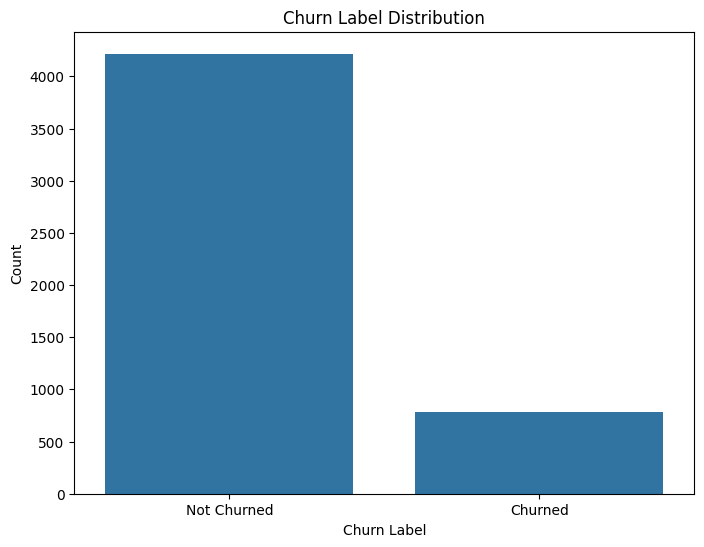


Value counts for CHURN_LABEL:
CHURN_LABEL
0    4217
1     783
Name: count, dtype: int64


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='CHURN_LABEL', data=data)
plt.title('Churn Label Distribution')
plt.xlabel('Churn Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Churned', 'Churned'])  # Assuming 0 = Not Churned, 1 = Churned
plt.show()

# Display the actual counts for churn labels
print("\nValue counts for CHURN_LABEL:")
print(data['CHURN_LABEL'].value_counts())

In [26]:
# Encode categorical variables
data = pd.get_dummies(data, columns=['SEGMENT', 'PLAN', 'COUNTRY'], drop_first=True)

In [27]:
# Normalize numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['AVG_MONTHLY_LOGINS', 'MRR', 'SUBSCRIPTION_DURATION']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [30]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X = data.drop('CHURN_LABEL', axis=1)  # Features
y = data['CHURN_LABEL']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [45]:
# 1. Encode remaining categorical columns
categorical_columns = ['INDUSTRY']  # Only include columns that haven't been encoded yet
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [46]:
# 2. Prepare features (X) and target (y)
# Remove CUSTOMER_ID, CHURN_LABEL, and CUSTOMER_STATUS_Churned from features
X = data_encoded.drop(['CUSTOMER_ID', 'CHURN_LABEL', 'CUSTOMER_STATUS'], axis=1)
y = data_encoded['CHURN_LABEL']

In [47]:
# 3. Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# 4. Scale the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_columns = ['MRR', 'SUBSCRIPTION_DURATION', 'AVG_MONTHLY_LOGINS',
                     'AVG_TICKETS_RAISED', 'AVG_FEATURE_USAGE']

In [49]:
# Create a copy of X_train and X_test as pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Scale only numerical columns
X_train_df[numerical_columns] = scaler.fit_transform(X_train_df[numerical_columns])
X_test_df[numerical_columns] = scaler.transform(X_test_df[numerical_columns])

In [50]:
# 5. Train and evaluate the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(random_state=42)
model.fit(X_train_df, y_train)

# Make predictions
y_pred = model.predict(X_test_df)

In [56]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the model on the oversampled data
model = LogisticRegression(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.985

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       845
           1       0.93      0.97      0.95       155

    accuracy                           0.98      1000
   macro avg       0.96      0.98      0.97      1000
weighted avg       0.99      0.98      0.99      1000


Confusion Matrix:
 [[834  11]
 [  4 151]]


C:\Users\Parth Badani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Top 10 Most Important Features:
                  Feature  Importance
1   SUBSCRIPTION_DURATION   12.308308
2      AVG_MONTHLY_LOGINS    3.982063
7             PLAN_Growth    3.163870
8                PLAN_Pro    1.140580
9          COUNTRY_Brazil    1.037213
25        INDUSTRY_Retail    0.828120
26    INDUSTRY_Technology    0.827398
24   INDUSTRY_Real Estate    0.820352
16             COUNTRY_UK    0.745403
19    INDUSTRY_Healthcare    0.724600


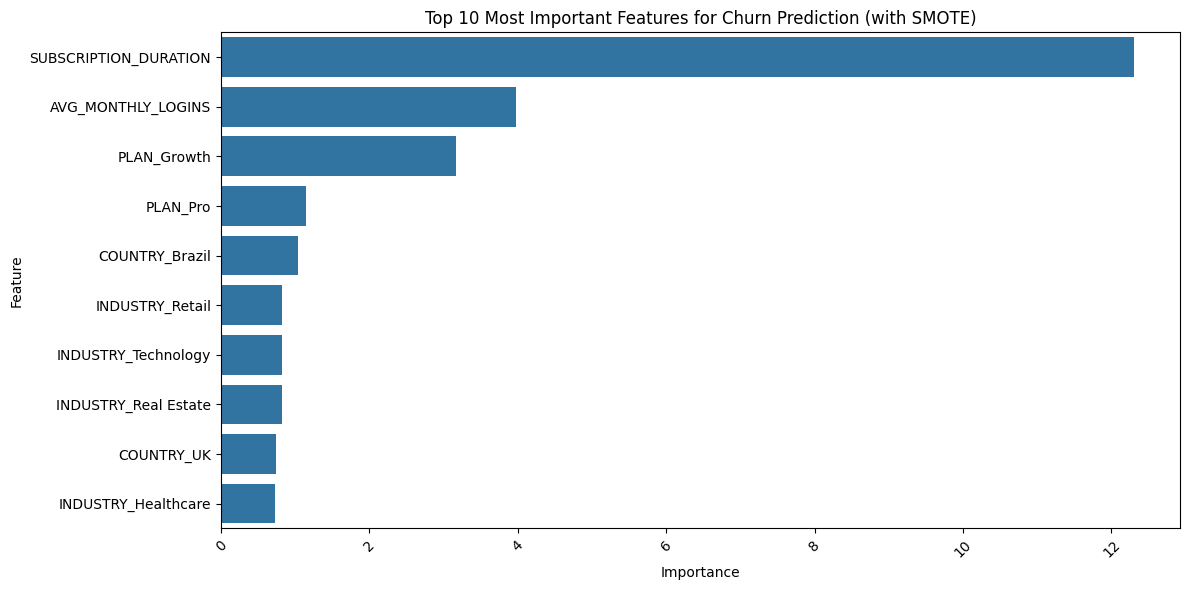

In [58]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Optional: Visualize feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features for Churn Prediction (with SMOTE)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the model with class weights
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.976

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       845
           1       0.87      0.99      0.93       155

    accuracy                           0.98      1000
   macro avg       0.94      0.98      0.96      1000
weighted avg       0.98      0.98      0.98      1000


Confusion Matrix:
 [[823  22]
 [  2 153]]


C:\Users\Parth Badani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Top 10 Most Important Features:
                   Feature  Importance
1    SUBSCRIPTION_DURATION   11.723121
7              PLAN_Growth    2.500749
2       AVG_MONTHLY_LOGINS    2.333340
10          COUNTRY_Canada    1.042173
8                 PLAN_Pro    1.008941
14           COUNTRY_Japan    0.793900
20      INDUSTRY_Logistics    0.755998
13           COUNTRY_India    0.714695
21  INDUSTRY_Manufacturing    0.591578
9           COUNTRY_Brazil    0.516090


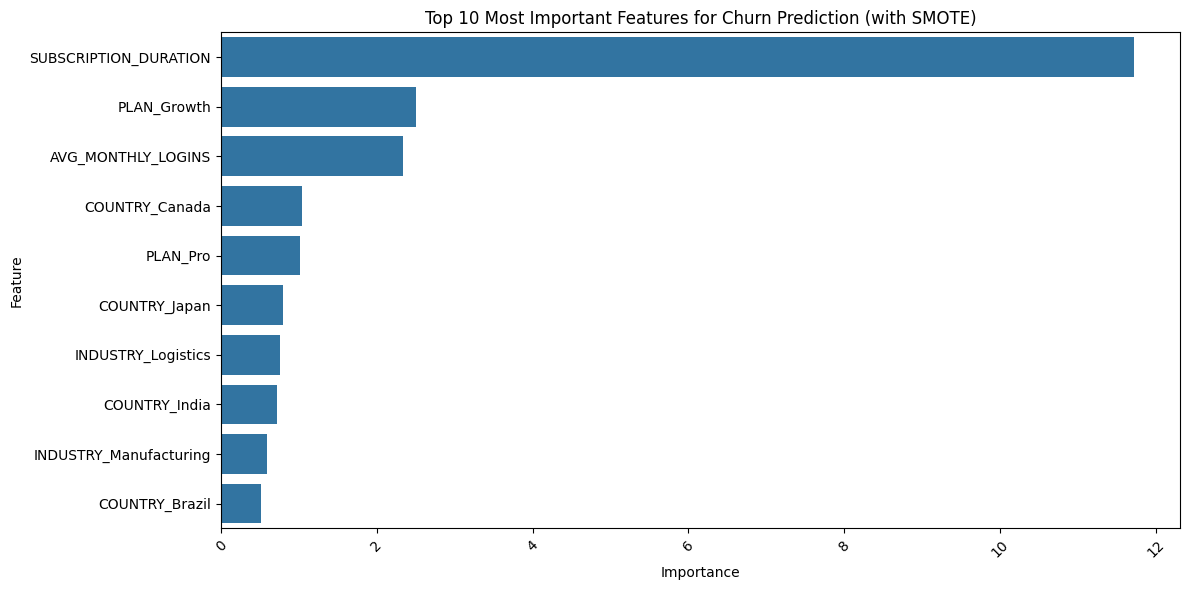

In [60]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Optional: Visualize feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features for Churn Prediction (with SMOTE)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
import pandas as pd
import numpy as np

# 1. Get predictions and probabilities for all data
# First, scale the numerical features for the entire dataset
numerical_columns = ['MRR', 'SUBSCRIPTION_DURATION', 'AVG_MONTHLY_LOGINS',
                    'AVG_TICKETS_RAISED', 'AVG_FEATURE_USAGE']

X_scaled = X.copy()
X_scaled[numerical_columns] = scaler.transform(X_scaled[numerical_columns])

# Get predictions and probabilities
predictions = model.predict(X_scaled)
prediction_probabilities = model.predict_proba(X_scaled)[:, 1]  # Probability of churn (class 1)

In [63]:
# Check the column names in the DataFrame
print("Available columns in the dataset:")
print(data.columns.tolist())

Available columns in the dataset:
['CUSTOMER_ID', 'INDUSTRY', 'MRR', 'SUBSCRIPTION_DURATION', 'CUSTOMER_STATUS', 'CHURN_LABEL', 'AVG_MONTHLY_LOGINS', 'AVG_TICKETS_RAISED', 'AVG_FEATURE_USAGE', 'SEGMENT_Mid-Market', 'SEGMENT_SMB', 'PLAN_Growth', 'PLAN_Pro', 'COUNTRY_Brazil', 'COUNTRY_Canada', 'COUNTRY_France', 'COUNTRY_Germany', 'COUNTRY_India', 'COUNTRY_Japan', 'COUNTRY_Singapore', 'COUNTRY_UK', 'COUNTRY_USA']


In [64]:
# First, let's load the original data again
file_path = 'C:/Users/Parth Badani/Downloads/2025-01-13 4_05pm.csv'
original_data = pd.read_csv(file_path)

In [65]:
# Create the final dataset
final_dataset = pd.DataFrame({
    # Customer Identification
    'CUSTOMER_ID': original_data['CUSTOMER_ID'],
    'SEGMENT': original_data['SEGMENT'],
    'INDUSTRY': original_data['INDUSTRY'],
    'COUNTRY': original_data['COUNTRY'],
    'PLAN': original_data['PLAN'],

    # Key Business Metrics
    'MRR': original_data['MRR'],
    'SUBSCRIPTION_DURATION': original_data['SUBSCRIPTION_DURATION'],

    # Usage Metrics
    'AVG_MONTHLY_LOGINS': original_data['AVG_MONTHLY_LOGINS'],
    'AVG_TICKETS_RAISED': original_data['AVG_TICKETS_RAISED'],
    'AVG_FEATURE_USAGE': original_data['AVG_FEATURE_USAGE'],

    # Actual and Predicted Churn
    'ACTUAL_CHURN': original_data['CHURN_LABEL'],
    'PREDICTED_CHURN': predictions,
    'CHURN_PROBABILITY': prediction_probabilities,

    # Current Status
    'CUSTOMER_STATUS': original_data['CUSTOMER_STATUS']
})

In [66]:
# Add Risk Level based on churn probability
def get_risk_level(probability):
    if probability < 0.3:
        return 'Low Risk'
    elif probability < 0.7:
        return 'Medium Risk'
    else:
        return 'High Risk'

final_dataset['RISK_LEVEL'] = final_dataset['CHURN_PROBABILITY'].apply(get_risk_level)

# Calculate Monthly Revenue at Risk
final_dataset['REVENUE_AT_RISK'] = final_dataset['MRR'] * final_dataset['CHURN_PROBABILITY']

In [67]:
# Save the final dataset
output_path = 'C:/Users/Parth Badani/churn_prediction_results.csv'
final_dataset.to_csv(output_path, index=False)
print(f"Main dataset saved as: {output_path}")

Main dataset saved as: C:/Users/Parth Badani/churn_prediction_results.csv


In [68]:
# Display sample of the final dataset
print("\nSample of the final dataset:")
print(final_dataset.head())


Sample of the final dataset:
   CUSTOMER_ID SEGMENT                    INDUSTRY    COUNTRY    PLAN   MRR  \
0            1     SMB  Financial Services/Fintech     France  Growth   210   
1            2     SMB       Professional Services      Japan  Growth   615   
2            3     SMB                   Education  Singapore     Pro  6468   
3            4     SMB  Financial Services/Fintech     Canada  Growth   780   
4            5     SMB                  Healthcare  Australia  Growth   900   

   SUBSCRIPTION_DURATION  AVG_MONTHLY_LOGINS  AVG_TICKETS_RAISED  \
0                    436          207.071429          101.357143   
1                   1078          201.235294           98.176471   
2                    281          656.333333          309.777778   
3                    661          157.000000           75.000000   
4                    845          184.000000          107.142857   

   AVG_FEATURE_USAGE  ACTUAL_CHURN  PREDICTED_CHURN  CHURN_PROBABILITY  \
0          5

In [69]:
# Display summary statistics
print("\nSummary of predictions:")
print(f"Total customers: {len(final_dataset)}")
print(f"Predicted churns: {sum(predictions)}")
print(f"Total monthly revenue at risk: ${final_dataset['REVENUE_AT_RISK'].sum():,.2f}")
print("\nRisk level distribution:")
print(final_dataset['RISK_LEVEL'].value_counts())


Summary of predictions:
Total customers: 5000
Predicted churns: 1480
Total monthly revenue at risk: $4,407,167.46

Risk level distribution:
RISK_LEVEL
Low Risk       3390
High Risk      1357
Medium Risk     253
Name: count, dtype: int64
